# Tutorial 7: Setup -- Policy Constraints

As show in previous tutorials, the settings file can be changed to adapt to a number of different systems. In Tutorial 3, we discussed how the setting Time Domain Reduction can reduce the computation time of the solver. Other settings, however, directly impact the values of the solution itself. This tutorial goes over the policy attributes in the settings and shows how implementing certain policies affects the optimal solution in GenX. To demonstrate these effects, we will be using `example_systems_tutorials/1_three_zones_tutorials`.

## Table of Contents
* [No Policy Constraints](#NoPolicies)
* [CO$_2$ Cap](#CO2Cap)
    * [Mass Cap](#MassCap)
        * [Tolerance](#Tolerance)
        * [CO$_2$ Slack](#CO2Slack)
    * [Load-based Cap](#LoadCap)
    * [Generator-based Cap](#GenerateCap)
* [Energy Share Requirement](#ESR)
* [Capacity Reserve Margin](#CRM)
* [Minimum Capacity Requriement](#MCR)
* [All Together](#All)
        

## No Policy Constraints <a id="NoPolicies"></a>

In [1]:
using JuMP
using HiGHS
using GenX
using CSV
using DataFrames
using Plots
using StatsPlots

In [1]:
case = joinpath("example_systems_tutorials/1_three_zones_tutorials") 

genx_settings = GenX.get_settings_path(case, "genx_settings.yml");
writeoutput_settings = GenX.get_settings_path(case, "output_settings.yml")
setup = GenX.configure_settings(genx_settings,writeoutput_settings)

LoadError: UndefVarError: `GenX` not defined

The settings we'll focus on here are , `CO2Cap`, `EnergyShareRequirement`, `CapacityReserveMargin`, and `MinCapReq`. Each of these ensures that the environmental impact of the model is taken into account, and are therefore referred to as __policy settings__ . For more information on what each one does, see the <a href="https://genxproject.github.io/GenX.jl/dev/Model_Reference/policies/" target="_blank">documentation</a>.

In [3]:
println("MaxCapReq: ", setup["MaxCapReq"])
println("MinCapReq: ", setup["MinCapReq"])
println("CO2Cap: ", setup["CO2Cap"])
println("EnergyShareRequirement: ", setup["EnergyShareRequirement"])
println("CapacityReserveMargin: ", setup["CapacityReserveMargin"])

MaxCapReq: 0
MinCapReq: 1
CO2Cap: 2
EnergyShareRequirement: 0
CapacityReserveMargin: 0


`1_three_zones` uses `MinCapReq` and `CO2Cap`. For the purpose of this tutorial, we're going to set these back to zero to start.

In [4]:
setup["MinCapReq"] = 0
setup["CO2Cap"] = 0;

Now, we'll generate and solve the model using these results:

In [5]:
## Delte Previous TDR Results
if "TDR_results" in cd(readdir,case)
    rm(joinpath(case,"TDR_results"), recursive=true) 
end

### Create TDR_Results
TDRpath = joinpath(case, setup["TimeDomainReductionFolder"])
system_path = joinpath(case, setup["SystemFolder"])
settings_path = GenX.get_settings_path(case)

if setup["TimeDomainReduction"] == 1
    GenX.prevent_doubled_timedomainreduction(system_path)
    if !GenX.time_domain_reduced_files_exist(TDRpath)
        println("Clustering Time Series Data (Grouped)...")
        GenX.cluster_inputs(case, settings_path, setup)
    else
        println("Time Series Data Already Clustered.")
    end
end


Clustering Time Series Data (Grouped)...
Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.



Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CSV Files Successfully Read In From example_systems/1_three_zones
Error: Geography Key 1 is invalid. Select `System' or `Zone'.


Dict{String, Any} with 9 entries:
  "RMSE"          => Dict("ME_NG"=>0.224076, "ME_onshore_wind_z3"=>0.317753, "D…
  "OutputDF"      => 1848×19 DataFrame…
  "ColToZoneMap"  => Dict("Demand_MW_z3"=>3, "CT_battery_z2"=>2, "MA_natural_ga…
  "ClusterObject" => KmeansResult{Matrix{Float64}, Float64, Int64}([-0.713315 -…
  "TDRsetup"      => Dict{Any, Any}("IterativelyAddPeriods"=>1, "ExtremePeriods…
  "Assignments"   => [1, 1, 1, 1, 2, 2, 2, 11, 2, 3  …  9, 9, 10, 10, 10, 10, 1…
  "InputDF"       => 1680×52 DataFrame…
  "Weights"       => [673.846, 842.308, 673.846, 673.846, 2021.54, 505.385, 168…
  "Centers"       => Any[4, 7, 12, 15, 24, 26, 29, 32, 42, 48, 52]

In [6]:
OPTIMIZER = GenX.configure_solver(settings_path,HiGHS.Optimizer);
inputs = GenX.load_inputs(setup, case)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CSV Files Successfully Read In From example_systems/1_three_zones


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Dict{Any, Any} with 67 entries:
  "Z"                         => 3
  "LOSS_LINES"                => [1, 2]
  "STOR_HYDRO_SHORT_DURATION" => Int64[]
  "RET_CAP_CHARGE"            => Set{Int64}()
  "pC_D_Curtail"              => [50.0, 45.0, 27.5, 10.0]
  "pTrans_Max_Possible"       => [5.9, 4.0]
  "pNet_Map"                  => [1.0 -1.0 0.0; 1.0 0.0 -1.0]
  "omega"                     => [4.01099, 4.01099, 4.01099, 4.01099, 4.01099, …
  "pMax_Line_Reinforcement"   => [2.95, 2.0]
  "RET_CAP_ENERGY"            => Int64[]
  "RESOURCES"                 => AbstractResource[…
  "COMMIT"                    => [1, 2, 3]
  "pMax_D_Curtail"            => [1.0, 0.04, 0.024, 0.003]
  "STOR_ALL"                  => [8, 9, 10]
  "THERM_ALL"                 => [1, 2, 3]
  "REP_PERIOD"                => 11
  "PWFU_Num_Segments"         => 0
  "STOR_LONG_DURATION"        => Int64[]
  "THERM_COMMIT_PWFU"         => Int64[]
  "STOR_SYMMETRIC"            => [8, 9, 10]
  "VRE"                       => [4, 

In [7]:
EP = GenX.generate_model(setup,inputs,OPTIMIZER)

Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module


A JuMP Model
Minimization problem with:
Variables: 120136
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97949 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eCFuelStart, eCNSE, eCStart, eCVa

In [8]:
GenX.solve_model(EP,setup)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
115667 rows, 69510 cols, 396959 nonzeros
108510 rows, 62353 cols, 397473 nonzeros
Presolve : Reductions: rows 108510(-44882); columns 62353(-57783); elements 397473(-73673)
Solving the presolved LP
IPX model has 108510 rows, 62353 columns and 397473 nonzeros
Input
    Number of variables:                                62353
    Number of free variables:                           3696
    Number of constraints:                              108510
    Number of equality constraints:                     16867
    Number of matrix entries:                           397473
    Matrix range:                                       [4e-07, 1e+01]
    RHS range:                                          [8e-01, 2e+01]
    Objective range:                                    [1e-04, 6e+02]
    Bounds range:                                       [1e-01, 2e+01]
Preprocessing
    Dualized model:                    

(A JuMP Model
Minimization problem with:
Variables: 120136
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97949 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eCFuelStart, eCNSE, eCStart, 

Using `value.()`, we can see what the total capacity is of the optimized model:

In [9]:
totCap_base = value.(EP[:eTotalCap])

10-element Vector{Float64}:
 12.72842675557979
 10.264611729659626
  0.19709703949102303
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

Each element corresponds to the MW value of the node in the grid. In `1_three_zones`, there are ten nodes, each of which are either natural gas, wind, solar, or battery plants. We can see which is which using `RESOURCE_NAMES` in the inputs dictionary:

In [10]:
RT = inputs["RESOURCE_NAMES"];
DataFrame([RT totCap_base],["Resource","Total Capacity"])

Row,Resource,Total Capacity
,Any,Any
1,MA_natural_gas_combined_cycle,12.7284
2,CT_natural_gas_combined_cycle,10.2646
3,ME_natural_gas_combined_cycle,0.197097
4,MA_solar_pv,0.0
5,CT_onshore_wind,0.0
6,CT_solar_pv,0.0
7,ME_onshore_wind,0.0
8,MA_battery,0.0
9,CT_battery,0.0


To visualize the impact of the emmissions policies, let's group the nodes together by type and plot the data.

In [11]:
# Group by plant type
totCapB = [totCap_base[1] + totCap_base[2] + totCap_base[3], totCap_base[4] + totCap_base[6], 
    totCap_base[5] + totCap_base[7], totCap_base[8] + totCap_base[9] + totCap_base[10]]
totCapB = reshape(totCapB,(:,1)) # Convert to matrix

4×1 Matrix{Float64}:
 23.19013552473044
  0.0
  0.0
  0.0

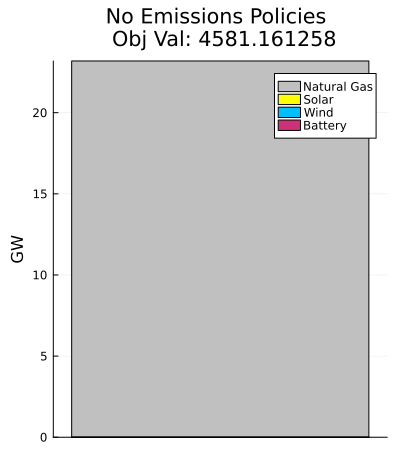

In [12]:
colors=[:silver :yellow :deepskyblue :violetred3]

G1 = groupedbar(transpose(totCapB), bar_position = :stack, bar_width=0.1,size=(400,450),
    labels=["Natural Gas" "Solar" "Wind" "Battery"],
    title="No Emissions Policies \n Obj Val: $(round(objective_value(EP),digits=6))",xticks=[ ],ylabel="GW",color=colors)

As you can see, with no limit on emissions, GenX goes straight to using natural gas. Let's try changing the settings to enforce emissions constraints.

## CO2 Cap <a id="CO2Cap"></a>

The setting <a href="https://genxproject.github.io/GenX/dev/policies/#CO_2-Constraint-Policy" target="_blank">`CO2Cap`</a> 
specifies if the model should have a constraint on CO$_2$ emmissions, and, if so, what that constraint should look like. There are three types, mass, load-based, and generator-based.

### Mass Cap <a id="MassCap"></a>

The first type of constraint, done by setting `CO2Cap` to "1", is a mass based constraint, which simply puts a limit on the total tons of CO$_2$ able to be produced per megawatt of electricty.

In [13]:
setup["CO2Cap"] = 1;

In [14]:
inputs = GenX.load_inputs(setup, case)
EP2 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP2,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module
Non-served Energy Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
115670 rows, 69510 cols, 408047 nonzeros
108251 rows, 62091 cols, 409589 nonzeros
Presolve : Reductions: rows 108251(-45144); columns 62091(-58048); elements 409589(-72648)
Solving the presolved LP
IPX model has 108251 rows, 62091 columns and 409589 nonzeros
Input
    Number of variables:                                62091
    Number of free variables:                           3696
    Number of constraints:                              108251
    Number of equality constraints:                     16605
    Number of matrix entries:      

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eC

In [15]:
totCap2 = value.(EP2[:eTotalCap])
totCapB2 = [totCap2[1] + totCap2[2] + totCap2[3], totCap2[4] + totCap2[6], 
    totCap2[5] + totCap2[7], totCap2[8] + totCap2[9] + totCap2[10]]

DataFrame([RT totCap2],["Resource Type","Total Capacity"])

Row,Resource Type,Total Capacity
,Any,Any
1,MA_natural_gas_combined_cycle,0.317743
2,CT_natural_gas_combined_cycle,0.471775
3,ME_natural_gas_combined_cycle,0.261152
4,MA_solar_pv,41.794
5,CT_onshore_wind,-0.0432064
6,CT_solar_pv,68.6136
7,ME_onshore_wind,5.69242
8,MA_battery,13.0116
9,CT_battery,30.7305


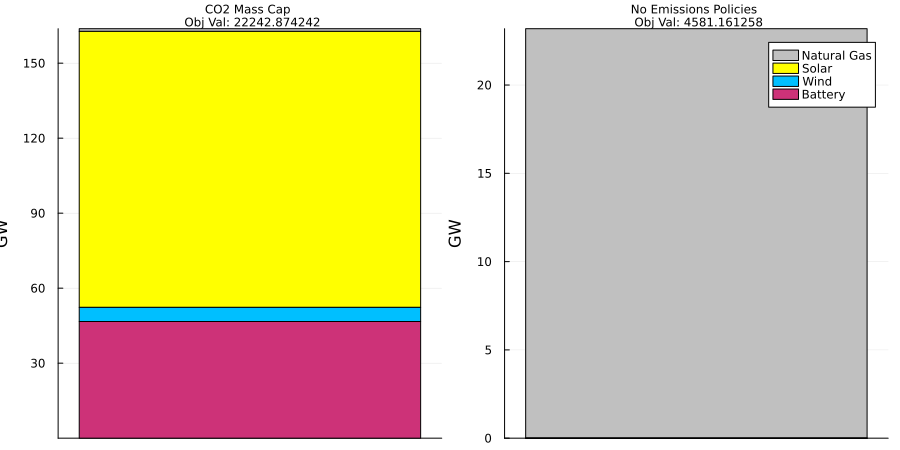

In [16]:
G2 = groupedbar(transpose(totCapB2), bar_position = :stack, bar_width=0.1,size=(100,450),
    labels=["Natural Gas" "Solar" "Wind" "Battery"],legend = false,title="CO2 Mass Cap \n Obj Val: $(round(objective_value(EP2),digits=6))",
xticks=[ ],ylabel="GW",color=colors)
plot(G2,G1,size=(900,450),titlefontsize=8)


The model favors solar power now, but natural gas and wind are also used. One thing to note is that the objective value of this system is much higher than it was without emissions constraints. The amount of CO$_2$ allowed is determined by the input file CO2_cap.csv:

In [17]:
CO2Cap =  CSV.read(joinpath(case,"policies/CO2_cap.csv"),DataFrame,missingstring="NA")

Row,Column1,Network_zones,CO_2_Cap_Zone_1,CO_2_Cap_Zone_2,CO_2_Cap_Zone_3,CO_2_Max_tons_MWh_1,CO_2_Max_tons_MWh_2,CO_2_Max_tons_MWh_3,CO_2_Max_Mtons_1,CO_2_Max_Mtons_2,CO_2_Max_Mtons_3
,String3,String3,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,MA,z1,1,0,0,0.05,0.0,0.0,0.018,0.0,0.0
2,CT,z2,0,1,0,0.0,0.05,0.0,0.0,0.025,0.0
3,ME,z3,0,0,1,0.0,0.0,0.05,0.0,0.0,0.025


#### Tolerance of Cap <a id="Tolerance"></a>

Let's try setting the CO$_2$ emissions tolerance to 0 for all nodes:

In [18]:
CO2Cap2 = copy(CO2Cap); # Save old tolerances

In [19]:
CO2Cap2[!,"CO_2_Max_tons_MWh_1"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_tons_MWh_2"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_tons_MWh_3"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_Mtons_1"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_Mtons_2"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_Mtons_3"] = [0.0;0.0;0.0];

In [20]:
CSV.write(joinpath(case,"policies/CO2_cap.csv"),CO2Cap2)

"example_systems/1_three_zones/policies/CO2_cap.csv"

In [21]:
inputs = GenX.load_inputs(setup, case)
EP3 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP3,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
60227 rows, 47331 cols, 180743 nonzeros
53262 rows, 40366 cols, 180469 nonzeros
Presolve : Reductions: rows 53262(-100133); columns 40366(-79773); elements 180469(-301768)
Solving the presolved LP
IPX model has 53262 rows, 40366 columns and 180469 nonzeros
Input
    Number of variables:                                40366
    Number of free variables:                           3696
    Number of constraints:                              53262
    Number of equality constraints:                     11515
    Number of

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eC

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  0.0
   2 │ CT_natural_gas_combined_cycle  0.0
   3 │ ME_natural_gas_combined_cycle  0.0
   4 │ MA_solar_pv                    42.5057
   5 │ CT_onshore_wind                0.0
   6 │ CT_solar_pv                    70.8036
   7 │ ME_onshore_wind                4.41277
   8 │ MA_battery                     14.5059
   9 │ CT_battery                     31.9995
  10 │ ME_battery                     2.36775
 
Objective Value: 23311.59685846901


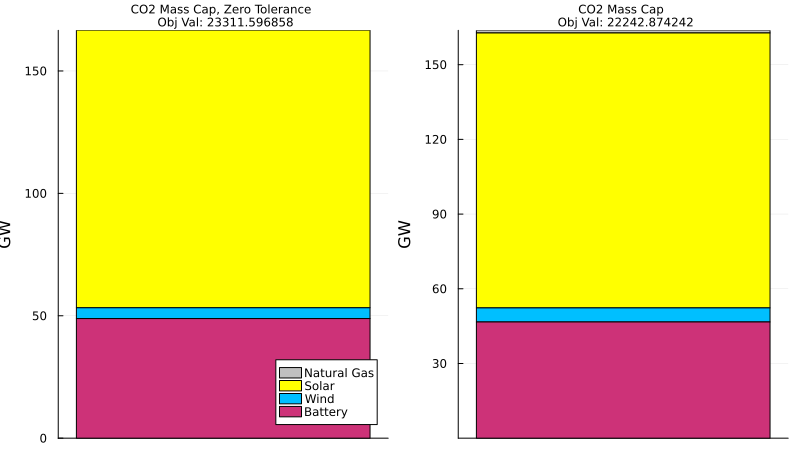

In [22]:
totCap3 = value.(EP3[:eTotalCap])

totCapB3 = [totCap3[1] + totCap3[2] + totCap3[3], totCap3[4] + totCap3[6], 
    totCap3[5] + totCap3[7], totCap3[8] + totCap3[9] + totCap3[10]]

println(DataFrame([RT totCap3],["Resource Type","Total Capacity"]))
println(" ")

println("Objective Value: ", objective_value(EP3))

G3 = groupedbar(transpose(totCapB3), bar_position = :stack, bar_width=0.1,size=(400,450), xticks=[ ],ylabel="GW",
    labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
    title="CO2 Mass Cap, Zero Tolerance \n Obj Val: $(round(objective_value(EP3),digits=6))")

plot(G3,G2,size=(800,450),titlefontsize=8)

As you can see, the use of natural gas has been eliminated compeltely. Note that the objective value increases here as well as renewable energy tends to cost more than natural gas.

#### CO$_2$ Slack Cap <a id="CO2Slack"></a>

Another thing we can do is, instead of demanding that the model 100% meet the CO$_2$ cap, we can add a penalty for if it violates the cap. This lets the system allow some CO$_2$ emmissions if it's determined the cost of the grid with some emmissions is low enough that it will offset the cost from the penalty variable. GenX will automatically incorporate this feature if a file by the name "CO2_cap_slack.csv" is in the policies folder of the directory. For more information on other types of policy slack variables in GenX, see the <a href="https://genxproject.github.io/GenX.jl/dev/User_Guide/slack_variables_overview/#Policy-Slack-Variables" target="_blank">documentation</a>.

Here, the CO$_2$ slack cap models a <a href="https://en.wikipedia.org/wiki/Carbon_tax#:~:text=A%20carbon%20tax%20is%20a,like%20more%20severe%20weather%20events.of" target="_blank">carbon tax</a> \$250 per ton of emissions.

In [23]:
CO2Cap_slack = DataFrame(["CO_2_Cap_Zone_1" 250; "CO_2_Cap_Zone_2" 250; "CO_2_Cap_Zone_2" 250],["CO2_Cap_Constraint","PriceCap"])

Row,CO2_Cap_Constraint,PriceCap
,Any,Any
1,CO_2_Cap_Zone_1,250
2,CO_2_Cap_Zone_2,250
3,CO_2_Cap_Zone_2,250


In [24]:
CSV.write(joinpath(case,"policies/CO2_cap_slack.csv"),CO2Cap_slack)

"example_systems/1_three_zones/policies/CO2_cap_slack.csv"

And run it again,

In [25]:
inputs = GenX.load_inputs(setup, case)
EP4 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP4,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
115667 rows, 69510 cols, 396959 nonzeros
108510 rows, 62353 cols, 397473 nonzeros
Presolve : Reductions: rows 108510(-44885); columns 62353(-57786); elements 397473(-84764)
Solving the presolved LP
IPX model has 108510 rows, 62353 columns and 397473 nonzeros
Input
    Number of variables:                                62353
    Number of free variables:                           3696
    Number of constraints:                              108510
    Number of equality constraints:                     16867
    Number

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116442 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCCO2Cap_slack, eCFix, eCFixEnergy

In [26]:
value.(EP4[:eCTotalCO2CapSlack])

2832.3575912069255

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  8.23751
   2 │ CT_natural_gas_combined_cycle  5.25036
   3 │ ME_natural_gas_combined_cycle  0.0
   4 │ MA_solar_pv                    12.244
   5 │ CT_onshore_wind                13.124
   6 │ CT_solar_pv                    4.74421
   7 │ ME_onshore_wind                9.37653
   8 │ MA_battery                     1.82649
   9 │ CT_battery                     2.47576
  10 │ ME_battery                     0.717964
 
Objective Value: 10213.909619463217


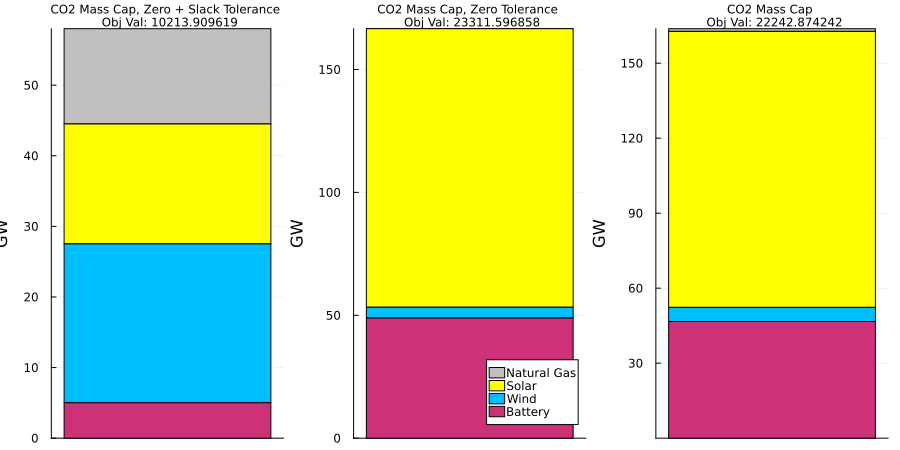

In [27]:
totCap4 = value.(EP4[:eTotalCap])

totCapB4 = [totCap4[1] + totCap4[2] + totCap4[3], totCap4[4] + totCap4[6], 
    totCap4[5] + totCap4[7], totCap4[8] + totCap4[9] + totCap4[10]]

println(DataFrame([RT totCap4],["Resource Type","Total Capacity"]))
println(" ")

println("Objective Value: ", objective_value(EP4))

G4 = groupedbar(transpose(totCapB4), bar_position = :stack, bar_width=0.1,size=(400,450), xticks=[ ],ylabel="GW",
    labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
    title="CO2 Mass Cap, Zero + Slack Tolerance \n Obj Val: $(round(objective_value(EP4),digits=6))")

plot(G4,G3,G2,size=(900,450),layout=(1,3),titlefontsize=8)

Adding in the slack variables allowed for some natural gas to be used once again and decreased the overall cost (objective function).

###  Load + Rate-Based CO$_2$ Cap <a id="LoadCap"></a>

Another way to set the CO$_2$ emissions cap is to limit emissions as a function of the total demand in that region. This can be done by setting `CO2Cap` to "2" in the setup:

In [28]:
setup["CO2Cap"] = 2;

Let's set the CO2_cap.csv back to it's original data, and remove the slack cap:

In [29]:
rm(joinpath(case,"policies/CO2_cap_slack.csv"))
CSV.write(joinpath(case,"policies/CO2_cap.csv"),CO2Cap)

"example_systems/1_three_zones/policies/CO2_cap.csv"

In [30]:
inputs = GenX.load_inputs(setup, case)
EP5 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP5,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
115670 rows, 69510 cols, 429602 nonzeros
108251 rows, 62091 cols, 431144 nonzeros
Presolve : Reductions: rows 108251(-45144); columns 62091(-58048); elements 431144(-84357)
Solving the presolved LP
IPX model has 108251 rows, 62091 columns and 431144 nonzeros
Input
    Number of variables:                                62091
    Number of free variables:                           3696
    Number of constraints:                              108251
    Number of equality constraints:                     16605
    Number of matrix entries:                           431144
    Matrix range:                  

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eC

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  7.87026
   2 │ CT_natural_gas_combined_cycle  2.57934
   3 │ ME_natural_gas_combined_cycle  0.641541
   4 │ MA_solar_pv                    17.3402
   5 │ CT_onshore_wind                17.5531
   6 │ CT_solar_pv                    11.1136
   7 │ ME_onshore_wind                11.767
   8 │ MA_battery                     2.60571
   9 │ CT_battery                     4.29039
  10 │ ME_battery                     1.1424
 


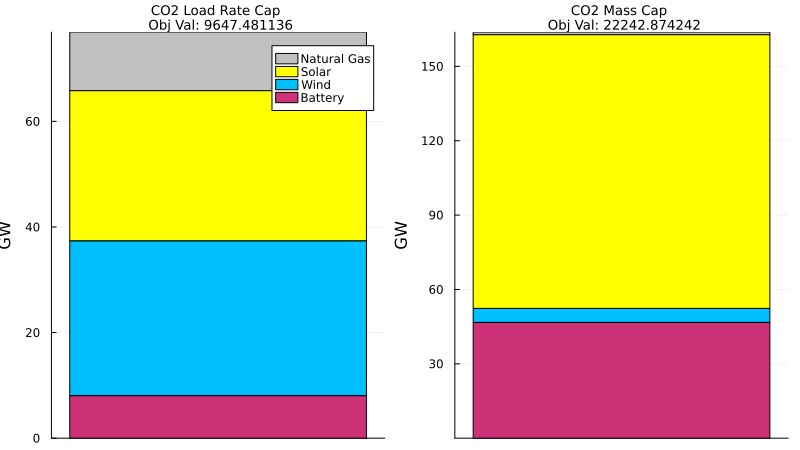

In [31]:
totCap5 = value.(EP5[:eTotalCap])

totCapB5 = [totCap5[1] + totCap5[2] + totCap5[3], totCap5[4] + totCap5[6], 
    totCap5[5] + totCap5[7], totCap5[8] + totCap5[9] + totCap5[10]]

toPlot = [transpose(totCapB2);transpose(totCapB5)]

println(DataFrame([RT totCap5],["Resource Type","Total Capacity"]))
println(" ")

G5 = groupedbar(transpose(totCapB5), bar_position = :stack, bar_width=.8,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
        title="CO2 Load Rate Cap \n Obj Val: $(round(objective_value(EP5),digits=6))")
plot(G5,G2,size=(800,450), titlefontsize=9)

### Generation + Rate-based CO$_2$ Cap <a id="GenerateCap"></a>

Finally, the third type of emissions cap in GenX is where the constraint is based on the ratio between the CO$_2$ cap and the generation of each node.

In [32]:
setup["CO2Cap"] = 3;

In [33]:
inputs = GenX.load_inputs(setup, case)
EP6 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP6,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module
Non-served Energy Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
CO2 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
115670 rows, 69510 cols, 413483 nonzeros
108251 rows, 62091 cols, 415025 nonzeros
Presolve : Reductions: rows 108251(-45144); columns 62091(-58048); elements 415025(-80148)
Solving the presolved LP
IPX model has 108251 rows, 62091 columns and 415025 nonzeros
Input
    Number of variables:                                62091
    Number of free variables:                           3696
    Number of constraints:                              108251
    Number of equality constraints:                     16605
    Number of matrix entries:      

(A JuMP Model
Minimization problem with:
Variables: 120139
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97952 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCO2Emissions_systemwide, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eC

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  4.35432
   2 │ CT_natural_gas_combined_cycle  5.58682
   3 │ ME_natural_gas_combined_cycle  1.17833
   4 │ MA_solar_pv                    20.6951
   5 │ CT_onshore_wind                17.5118
   6 │ CT_solar_pv                    9.22156
   7 │ ME_onshore_wind                11.2429
   8 │ MA_battery                     2.81436
   9 │ CT_battery                     4.09803
  10 │ ME_battery                     1.17376
 


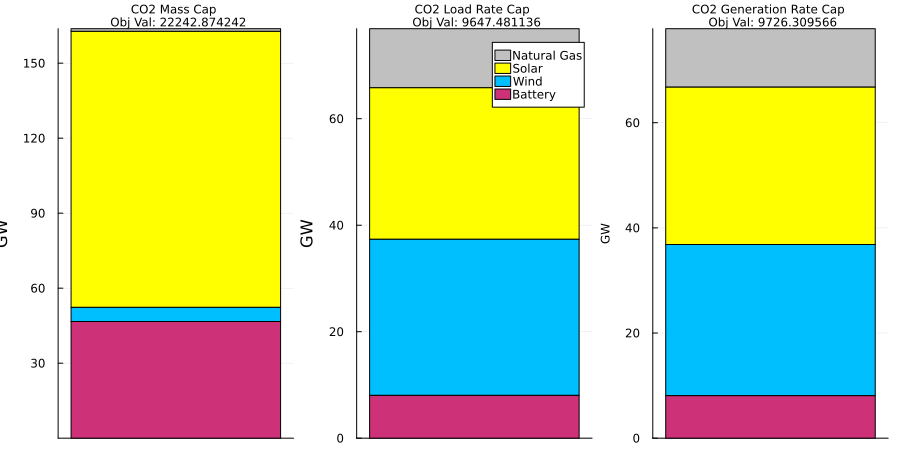

In [34]:
totCap6 = value.(EP6[:eTotalCap])

totCapB6 = [totCap6[1] + totCap6[2] + totCap6[3], totCap6[4] + totCap6[6], 
    totCap6[5] + totCap6[7], totCap6[8] + totCap6[9] + totCap6[10]]

println(DataFrame([RT totCap6],["Resource Type","Total Capacity"]))
println(" ")

G6 = groupedbar(transpose(totCapB6), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
        title="CO2 Generation Rate Cap \n Obj Val: $(round(objective_value(EP6),digits=6))",ylabelfontsize=8)
plot(G2,G5,G6,size=(900,450), titlefontsize=8,layout=(1,3),)

## Energy Share Requirement <a id="ESR"></a>

Many countries have policies that demand a certain percentage of energy provided to consumers comes from renewable energy (in the US, these are called <a href="https://www.eia.gov/energyexplained/renewable-sources/portfolio-standards.php#:~:text=Renewable%20portfolio%20standards%20(RPS)%2C,energy%20sources%20for%20electricity%20generation" target="_blank">renewable portfolio standards</a>.) In GenX, this policy can be implemented by setting <a href="https://genxproject.github.io/GenX.jl/dev/Model_Reference/policies/#Energy-Share-Requirement " target="_blank">`Energy_share_requirement`</a> to 1 in the setup, and adding a file called `Energy_share_requirement.csv` to the policies folder.

In [35]:
ESR =  CSV.read(joinpath(case,"policies/Energy_share_requirement.csv"),DataFrame,missingstring="NA")

Row,Column1,Network_zones,ESR_1,ESR_2
,String3,String3,Float64,Float64
1,MA,z1,0.259,0.348
2,CT,z2,0.44,0.44
3,ME,z3,0.776,0.776


In [36]:
setup["CO2Cap"] = 0 # set back to 0 to compare
setup["EnergyShareRequirement"] = 1;

In [37]:
inputs = GenX.load_inputs(setup, case)
EP7 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP7,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Energy_share_requirement.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
Energy Share Requirement Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
115669 rows, 69510 cols, 407831 nonzeros
108511 rows, 62353 cols, 402909 nonzeros
Presolve : Reductions: rows 108511(-44883); columns 62353(-57783); elements 402909(-83021)
Solving the presolved LP
IPX model has 108511 rows, 62353 columns and 402909 nonzeros
Input
    Number of variables:                                62353
    Number of free variables:                           3696
    Number of constraints:                              108511
    Number of equality constraints:                

(A JuMP Model
Minimization problem with:
Variables: 120136
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 35112 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20333 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97949 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 116439 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cESRShare, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCFuelOut, eCFuelStart, eCNSE

10×2 DataFrame
 Row │ Resource Type                  Total Capacity 
     │ Any                            Any            
─────┼───────────────────────────────────────────────
   1 │ MA_natural_gas_combined_cycle  10.6248
   2 │ CT_natural_gas_combined_cycle  8.19765
   3 │ ME_natural_gas_combined_cycle  0.0
   4 │ MA_solar_pv                    0.914951
   5 │ CT_onshore_wind                6.63242
   6 │ CT_solar_pv                    0.0
   7 │ ME_onshore_wind                6.33801
   8 │ MA_battery                     0.32888
   9 │ CT_battery                     0.0
  10 │ ME_battery                     0.485802
 


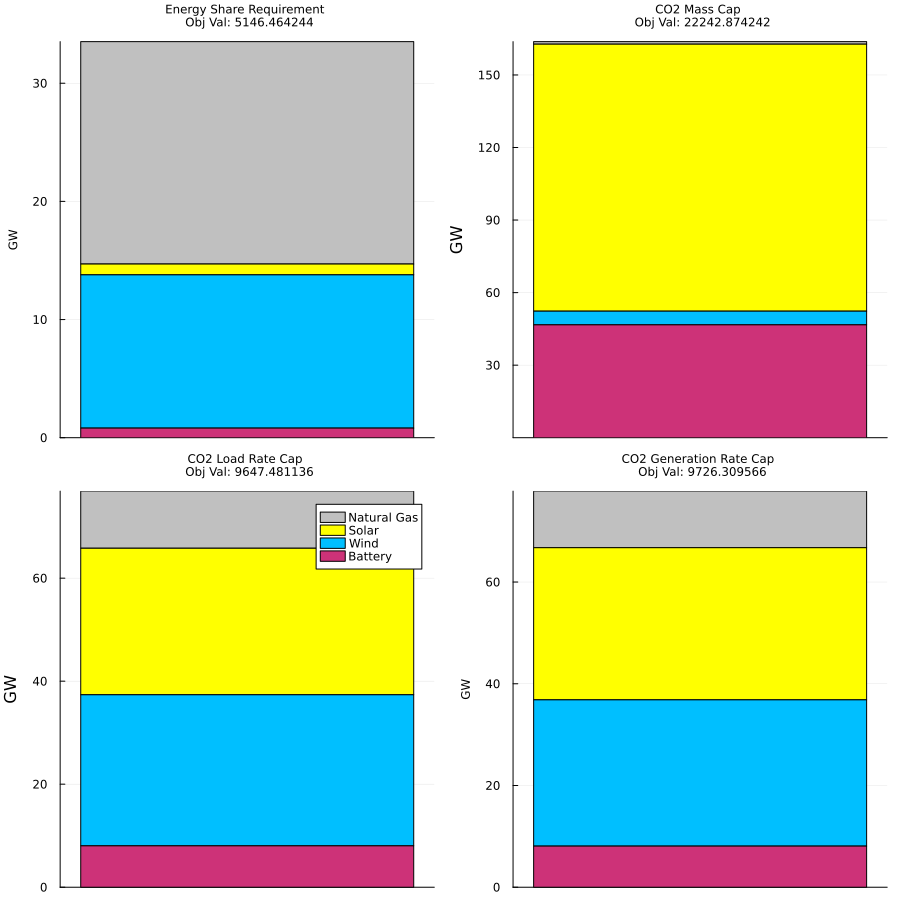

In [38]:
totCap7 = value.(EP7[:eTotalCap])

totCapB7 = [totCap7[1] + totCap7[2] + totCap7[3], totCap7[4] + totCap7[6], 
    totCap7[5] + totCap7[7], totCap7[8] + totCap7[9] + totCap7[10]]

println(DataFrame([RT totCap7],["Resource Type","Total Capacity"]))
println(" ")

G7 = groupedbar(transpose(totCapB7), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
        title="Energy Share Requirement \n Obj Val: $(round(objective_value(EP7),digits=6))",ylabelfontsize=8)
plot(G7,G2,G5,G6,size=(900,900), titlefontsize=8,layout=(2,2))

The Energy Share Requriement policy also has the possibiliy to be run with <a href="https://genxproject.github.io/GenX.jl/dev/User_Guide/slack_variables_overview/#Energy-Share-Requirement" target="_blank">slack variables</a>.

## Capacity Reserve Margin <a id="CRM"></a>

The  <a href="https://genxproject.github.io/GenX.jl/dev/Model_Reference/policies/#Capacity-Reserve-Margin" target="_blank">Capacity Reserve Margin</a> constraint demands that a certain amount of energy always be available in each zone, expressed as a fraction of the demand. Once again, we can enforce a Capacity Reserve Margin by setting its option to "1" in the setup and adding the relevant file, `Capacity_reserve_margin.csv`.

In [39]:
CapacityReserve =  CSV.read(joinpath(case,"policies/Capacity_reserve_margin.csv"),DataFrame,missingstring="NA")

Row,Column1,Network_zones,CapRes_1
,String3,String3,Float64
1,MA,z1,0.156
2,CT,z2,0.156
3,ME,z3,0.156


In [40]:
setup["CapacityReserveMargin"] = 1;

In [41]:
inputs = GenX.load_inputs(setup, case)
EP8 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP8,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Demand (load) data Successfully Read!
Fuels_data.csv Successfully Read!

Summary of resources loaded into the model:
-------------------------------------------------------
	Resource type 		Number of resources
	Thermal        		3
	VRE            		4
	Storage        		3
Total number of resources: 10
-------------------------------------------------------
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!


[ Info: Thermal.csv Successfully Read.
[ Info: Vre.csv Successfully Read.
[ Info: Storage.csv Successfully Read.
[ Info: Resource_energy_share_requirement.csv Successfully Read.
[ Info: Resource_capacity_reserve_margin.csv Successfully Read.
[ Info: Resource_minimum_capacity_requirement.csv Successfully Read.


Energy_share_requirement.csv Successfully Read!
CSV Files Successfully Read In From example_systems/1_three_zones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Fuel Module
CO2 Module
Investment Transmission Module
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
Energy Share Requirement Policies Module
Capacity Reserve Margin Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
128605 rows, 86142 cols, 501350 nonzeros
121146 rows, 78684 cols, 505582 nonzeros
Presolve : Reductions: rows 121146(-45184); columns 78684(-58084); elements 505582(-85576)
Solving the presolved LP
IPX model has 121146 rows, 78684 columns and 505582 nonzeros
Input
    Number of variables:                                78684
    

(A JuMP Model
Minimization problem with:
Variables: 136768
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 40656 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 27725 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 97949 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 133071 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: FuelCalculationCommit_single, cCapacityResMargin, cESRShare, cFuelCalculation_single, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSOCMinCapRes, cSoCBalInterior, cSoCBalStart, cStartFuel_single, cTAuxLimit, cTAuxSum, cTLoss, cVSoCBalInterior, cVSoCBalStart,

In [ ]:
totCap8 = value.(EP8[:eTotalCap])

totCapB8 = [totCap8[1] + totCap8[2] + totCap8[3], totCap8[4] + totCap8[6], 
    totCap8[5] + totCap8[7], totCap8[8] + totCap8[9] + totCap8[10]]

println(DataFrame([RT totCap8],["Resource Type","Total Capacity"]))
println(" ")

G8 = groupedbar(transpose(totCapB8), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
        title="Capacity Reserve Margin + ESR \n Obj Val: $(round(objective_value(EP8),digits=6))",ylabelfontsize=8)

plot(G8,G7,G2,size=(900,450), titlefontsize=8,layout=(1,3))

Capacity Reserve Margin also has the possibiliy to be run with <a href="https://genxproject.github.io/GenX.jl/dev/User_Guide/slack_variables_overview/#Capacity-Reserve-Margin" target="_blank">slack variables</a>.

## Minimum Capacity Requirement <a id="MCR"></a>

The last policy we'll talk about is <a href="https://genxproject.github.io/GenX.jl/dev/Model_Reference/policies/#Minimum-Capacity-Requirement" target="_blank">Minimum Capacity</a>,  which requires the grid to produce at least a certain amount of energy from renewables, as specified in the input file:

In [ ]:
MinCapacity =  CSV.read(joinpath(case,"policies/Minimum_capacity_requirement.csv"),DataFrame,missingstring="NA")

This policy ensures some renewable energy is used in the grid regardless of emissions constraints. If a fourth column containing price cap requirements exists (not shown above), that column is treated as a <a href="https://genxproject.github.io/GenX.jl/dev/User_Guide/slack_variables_overview/#Minimum-Capacity-Requirement" target="_blank">slack variable</a>.

In [ ]:
setup["CapacityReserveMargin"] = 0
setup["EnergyShareRequirement"] = 0
setup["MinCapReq"] = 1;

In [ ]:
inputs = GenX.load_inputs(setup, case)
EP9 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP9,setup)

In [ ]:
totCap9 = value.(EP9[:eTotalCap])

totCapB9 = [totCap9[1] + totCap9[2] + totCap9[3], totCap9[4] + totCap9[6], 
    totCap9[5] + totCap9[7], totCap9[8] + totCap9[9] + totCap9[10]]

println(DataFrame([RT totCap9],["Resource Type","Total Capacity"]))
println(" ")

G9 = groupedbar(transpose(totCapB9), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
        title="Minimum Capacity Requirement \n Obj Val: $(round(objective_value(EP9),digits=6))",ylabelfontsize=8)

plot(G9,G8,G7,G2,size=(900,900), titlefontsize=8,layout=(2,2))

## All Together <a id="All"></a>

`1_three_zones` has defaults of `CO2Cap = 2` and `MinCapReq = 1`. To see how everything comes together, let's add ESR and CRM in as well:

In [ ]:
setup["MinCapReq"] = 1
setup["CO2Cap"] = 2
setup["EnergyShareRequirement"] = 1
setup["CapacityReserveMargin"] = 1;

In [ ]:
inputs = GenX.load_inputs(setup, case)
EP10 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP10,setup)

In [ ]:
totCap10 = value.(EP10[:eTotalCap])

totCapB10 = [totCap10[1] + totCap10[2] + totCap10[3], totCap10[4] + totCap10[6], 
    totCap10[5] + totCap10[7], totCap10[8] + totCap10[9] + totCap10[10]]

println(DataFrame([RT totCap10],["Resource Type","Total Capacity"]))
println(" ")

G10 = groupedbar(transpose(totCapB10), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
        title="MCR + ESR + CSM + CO2 Load Cap \n Obj Val: $(round(objective_value(EP10),digits=6))",ylabelfontsize=8)

plot(G10, titlefontsize=8)